# Formalia:

Please read the [assignment overview page](https://github.com/SocialComplexityLab/socialgraphs2021/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc.), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Tuesday November the 2nd, 2021 at 23:59. Hand in your IPython notebook file (with extension `.ipynb`) via http://peergrade.io/

### Overview

This year's Assignment 2 is all about analyzing the network of The Legend of Zelda: Breath of the Wild.

Note that this time I'm doing the exercises slightly differently in order to clean things up a bit. The issue is that the weekly lectures/exercises include quite a few instructions and intermediate results that are not quite something you guys can meaningfully answer. 

Therefore, in the assignment below, I have tried to reformulate the questions from the weekly exercises into something that is (hopefully) easier to answer. *Then I also note which lectures each question comes from*; that way, you can easily go back and find additional tips & tricks on how to solve things 😇


----

# Part 0: Building the network 

To create our network, we downloaded the Zelda Wiki pages for all characters in BotW (during Week 4) and linked them via the hyperlinks connecting pages to each other. To achieve this goal we have used regular expressions!

> * Explain the strategy you have used to extract the hyperlinks from the Wiki-pages, assuming that you have already collected the pages with the Zelda API.
> * Show the regular expression(s) you have built and explain in details how it works.

In [369]:
import urllib
import re
import pandas as pd
import io
import requests
from pathlib import Path
import numpy as np
import networkx as nx
from zipfile import ZipFile
from fa2 import ForceAtlas2
import matplotlib.pyplot as plt
import seaborn as sns
import powerlaw

import requests
import nltk
from typing import List
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import rbo 
from scipy.stats import ttest_ind, normaltest
# Divide graph into communities
import community as community_louvain


import urllib.request
import json
import os
import regex as re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from wordcloud import WordCloud, ImageColorGenerator

import community
from community import community_louvain
import math
import seaborn as sns

#### The .txt files extracted using the Zelda API for each character are uploaded from a local folder "characters/" (zipped)

In [265]:
#Extract the pages with the characters' description from the Zelda API from local folder
# Extract all the files
with ZipFile("characters.zip", 'r') as zipFile:
    zipFile.extractall()
    
path = "characters/"

In [278]:
#Read the ZeldaBotW_nodes_w_attributes_enriched.CSV file into a Pandas df
url= "https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2021/main/files/ZeldaBotW_nodes_w_attributes_enriched.csv"
df = pd.read_csv(url)
#Add a column with the word count of each character page
df['Word_count'] = [len(re.findall(r'\w+',open(path+word+".txt","r").read())) if word != 'Granté' else 0 for word in df['Name']]


In [317]:
links = []

#For each character in the csv, extract the links to the nodes in the descripton file
path = "characters/"

for node in df["Name"]:
    with open(path+node+".txt","r") as f:
        node_description = f.read()
    #hypyerlink regex that link to another node of the network (e.g. another character). 
    pattern1 = r'\[\[(.*?)(?:\|.*?|\#Breath of the Wild)?\]\]'
    pattern2 = r'\{\{(?:Plural|Term)\|BotW\|(.*?)(?:\|display.*?)?(\|link)?\}\}'
    pattern3 = r'\{\{(?:Plural|Term)\|Series\|(.*?)(?:\|display.*?)?(\|link)?\}\}'
    #Find patterns of two types and filter non-links using regex patterns
    links_pattern1 = list(re.findall(pattern1, node_description))
    links_pattern2 = [l[0] for l in re.findall(pattern2, node_description) if "|link" in l]
    links_pattern3 = [l[0] for l in re.findall(pattern3, node_description) if "|link" in l]
    #Append them to a list
    #Check if the matches are valid by comparing them with the names in the characters' list
    links_total = [l for l in set(links_pattern1+links_pattern2+links_pattern3) if l in df.Name.values]
    links.append(links_total)

In [318]:
#Create NetworkX DiGraph to store the network
G = nx.DiGraph()
nodes_with_attributes = [(df.Name[i],{'Role':df.Role[i],'Race':df.Race[i],'Gender':df.Gender[i], 'Word_count':df.Word_count[i]}) for i in df.index]
#First, add the nodes with the attributes
G.add_nodes_from(nodes_with_attributes)
#Second, add the edges, represented by the list of hyperlinks for each node
list_dict = {df.Name.values[i]: x for i,x in enumerate(links) for y in x if (y in df.Name.values)}
#Remove self references
G.add_edges_from([(x,i) for x in list_dict for i in list_dict[x] if x!=i ] )
print(f'num nodes: {G.number_of_nodes()}')
print(f'num edges: {G.number_of_edges()}')

num nodes: 656
num edges: 1784


In [333]:
#Remove isolated nodes from the network
G.remove_nodes_from(list(nx.isolates(G)))
# Extract the largest component LC
LC = max(nx.weakly_connected_components(G),key=len)
#Save only the largest component as G
GG = nx.DiGraph(G.subgraph(LC))
#Undirected Graph
G_undirected = GG.to_undirected()

In [320]:
print(f'num nodes after removing isolates: {G.number_of_nodes()}')
print(f'num edges after removing isolates: {G.number_of_edges()}')

num nodes after removing isolates: 546
num edges after removing isolates: 1784


> **Explain the strategy you have used to extract the hyperlinks from the Wiki-pages, assuming that you have already collected the pages with the Zelda API.**


> **Part 0 of the Assignment is meant to explain what you have done to extract the hyperlinks from the pages. Do not show the code that you have used to get the pages with the API or the characters. Instead, show the code that reads the pages and finds the hyperlinks with regex.** 
> **Explain the steps and strategy you have used. Plus, remember to explain how you built the regex patterns (explain every part of it, how it works, what it captures, why you chose to use that pattern, and whether you added any post processing step)**


The overall strategy for building is the following: 
<ol>
<li> We extracted the pages downloaded for each character from the zip file included in the folder. Each page corresponds to a character, which is a node in the network. 
<li> We used the <a href="https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2021/main/files/ZeldaBotW_nodes_w_attributes_enriched.csv">csv file</a>
    provided on Gihub  to find the Name, Race, Role and Gender of a character.
<li>Then, we found all the hyperlinks in a character's page that link to another node of the network (e.g. another character). We use regular expressions to extract all outgoing links from each of the pages you downloaded above. For each link, we checked if the target was a character. If yes, we kept it. If no, we discarded it.
<li> To build the network, we used a NetworkX DiGraph to store the network. We also stored the properties of the nodes (i.e. Role, Race, and Gender, Word Count). By storing this information as nodal features, we keep all the relevant data in one place.
<li> To clean the network, we removed the isolated nodes (ie. nodes that do not have any edge) from the network.
<li> Additionally, we extracted the largest component to make visualizations much easier. 
<li> For the sake of the visualisation, we converted our network to an undirected graph.
</ol>


> **Show the regular expression(s) you have built and explain in details how it works.**

In our approach, we used 2 regular expressions to extract all outgoing links from each of the Wiki pages:
<ol>
    <li>The first pattern <code>r'\[\[(.*?)(?:\|.*?|\#Breath of the Wild)?\]\]'</code> is used to extract direct links (i.e. <code>[[name of character]]</code>) and links to sections of another page (i.e. <code>[[Link#Breath of the Wild]]</code> or links using text (i.e <code>[[Princess Zelda|Zelda]]</code>) that contain square brackets. It consists of: 
     <ol>  
        <li> A capturing group <code>(.*?)</code> which matches the first part of the link (the name of the character or otherwise), previous token between zero and one times, as many times as possible. 
            <ol>  
             <li> <code>.</code> matches any character (except for line terminators)
             <li> <code>*?</code> matches the previous token between zero and unlimited times, as few times as possible, expanding as needed
            </ol>
         <li> A non-capturing group <code>(?:\|.*?|\#Breath of the Wild)</code> which matches the characters included in the group but does not capture the group. It is used to identify links composed of two parts, separated by <code>|</code> character or links which point to sections of another page in their description (i.e. <code>[[Link#Breath of the Wild]]</code>).
             <ol>  
                 <li> <code>?:</code> defines the non-capturing group matches any character (except for line terminators)
                 <li> <code>\</code> is used in regular expressions to escape the next character, a vertical line in our case.
                 <li> <code>\|.*?</code> matches any character delimited by a vertical line and followed by matches any character (<code>.</code>), which matches the previous token between zero and unlimited times, as few times as possible, expanding as needed (<code>*?</code>)
                 <li><code>|</code> the vertical bar is used to define alternation, which is an OR statement between multiple expressions.
                 <li> <code>\#Breath of the Wild</code> matches the text <code>#Breath of the Wild</code>
             </ol>
     </ol>
    <li>The second pattern <code>r'\{\{(?:Plural|Term)\|BotW\|(.*?)(?:\|display.*?)?(\|link)?\}\ </code> is used to identify links using plural terms and links to pages that have curly parentheses. It consists of: 
        <ol>  
            <li>A non-capturing group <code>(?:Plural|Term)</code> which identifies the links that start with the word <code>Plural</code> or <code>Term</code> (ie. <code>{{Plural|Series|Heart|link}}</code>)
            <li>The text <code>\|BotW\|</code> which matches the second part of the link delimited by vertical bars, for characters identified in direct links (ie. <code>{{Term|BotW|name of character|link}}</code>)
            <li>A first capturing group <code>(.*?)</code> which:
                <ol> 
                   <li><code>.</code> matches any character (except for line terminators)
                   <li> <code>*?</code> matches the previous token between zero and unlimited times, as few times as possible, expanding as needed 
                </ol>
                <li>A first non-capuring group (<code>(?:\|display.*?)</code> which identifies the characters included in the group but does not capture the group. It is used to match the links which have the name <code>display</code> in the link (ie. <code>{{Term|Series|Princess Zelda|link|display=Zelda}}</code>)
                <ol>    
                   <li> <code>display</code> matches the text
                   <li><code>.</code> matches any character (except for line terminators)
                   <li><code>*?</code> matches the previous token between zero and unlimited times, as few times as possible, expanding as needed (lazy)
                    </ol>
                <li><code>?</code> matches the previous token between zero and one times, as many times as possible, giving back as needed 
                <li>A second capturing group <code>(\|link)</code> which identifies the <code>link</code> text in hyperlinks such as <code>{{Term|BotW|Sheikah|link}</code>.
        </ol>
        <li>The third pattern <code>r'\{\{(?:Plural|Term)\|Series\|(.*?)(?:\|display.*?)?(\|link)?\}\ </code> is used to identify links using plural terms and links to pages that have curly parentheses. It works the same way as the second one, except that it matches links which contain the word <code>Series</code> instead of <code>BotW</code>
</ol>


# Part 1: Network visualization and basic stats

Visualize the network (from lecture 5) and calculate stats (from lecture 4 and 5). For this exercise, we assume that you've already generated the BotW network and extracted the giant connected component. Use the GCC to report the results.

Exercise 1a: Stats (see lecture 4 and 5 for more hints)

> * What is the number of nodes in the network?
> * What is the number of links?
> * Who is the top connected character in BotW? (Report results for the in-degrees and out-degrees). Comment on your findings. Is this what you would have expected?
> * Who are the top 5 most connected allies (again in terms of in/out-degree)?
> * Who are the top 5 most connected enemies -- bosses included -- (again in terms of in/out-degree)?
> * Plot the in- and out-degree distributions.
>   * What do you observe?
>   * Can you explain why the in-degree distribution is different from the out-degree distribution?
> * Find the exponent of the degree distribution (by using the powerlaw package) for the in- and out-degree distribution. What does it say about our network?
> * Compare the degree distribution of the undirected graph to a random network with the same number of nodes and probability of connection p. Comment your results.

**_Exercise 1a_: Stats (see lecture 4 and 5 for more hints)**

> **What is the number of nodes in the network? What is the number of links?**

In [321]:
#number of nodes
print(f'Nodes: {len(list(G_undirected.nodes()))}')
#number of links
print(f'Links: {G.number_of_edges()}')

Nodes: 535
Links: 1784



>**Who is the top connected character in BotW? (Report results for the in-degrees and out-degrees).**
>**Comment on your findings. Is this what you would have expected?**

In [324]:
#list of in-degrees
in_deg = [v for k, v in dict(G.in_degree).items()]
#list of out-degrees
out_deg =  [v for k, v in dict(G.out_degree).items()]

In [325]:
#sort the in and out-degree lists and extract the top value
top_character_in = sorted([(node, degree) for node, degree in G.in_degree], key=lambda t: t[1])[-1]
top_character_out = sorted([(node, degree) for node, degree in G.out_degree], key=lambda t: t[1])[-1]
print(f'The top connected character (in-degrees) is {top_character_in[0]} with {top_character_in[1]} links.')
print(f'The top connected character (out-degrees) is {top_character_out[0]} with {top_character_out[1]} links.')

The top connected character (in-degrees) is Link with 395 links.
The top connected character (out-degrees) is Traysi with 14 links.


The in-degree of node i is the total number of connections onto node i, representing the number of other hyperlinks from other Wiki pages that point to a selected character. The top connected character in the in-degrees list is Link, with 396 links. This is expected, as Link is the main character, which is referenced by most of the other characters in their Wiki pages. 

On the other hand, the out-degree of node i is the total number of connections coming from node i, representing the number of hyperlinks that point from the current character page to other character pages. The top connected character in the out-degrees list is Traysi, with 14 degrees. According to her Wiki page, Traysi is a Hylian investigative journalist who can be found researching her next story in Gerudo Town. It makes sense that she is the top connected character, because she references most of the other characters in her page, due to the nature of her role.

> **Who are the top 5 most connected allies (again in terms of in/out-degree)?**

In [326]:
#sort the in and out-degree lists and extract the top 5 Allies from each
allies = [(node, degree) for node, degree in G.in_degree if G.nodes[node]['Role']=='Ally' ]
top_ally_in = sorted([(node, degree) for node, degree in allies], key=lambda t: t[1])[-5:]
top_ally_out = sorted([(node, degree) for node, degree in allies], key=lambda t: t[1])[-5:]
print(f'Top 5 most connected allies (in-degree): {top_ally_in}')
print(f'Top 5 most connected allies (outt-degree): {top_ally_out}')

Top 5 most connected allies (in-degree): [('Mipha', 18), ('Princess Zelda', 22), ('Riju', 22), ('Hylia', 67), ('Link', 395)]
Top 5 most connected allies (outt-degree): [('Mipha', 18), ('Princess Zelda', 22), ('Riju', 22), ('Hylia', 67), ('Link', 395)]


> **Who are the top 5 most connected enemies -- bosses included -- (again in terms of in/out-degree)?**

In [327]:
#sort the in and out-degree lists and extract the top 5 Ennemies from each
ennemies = [(node, degree) for node, degree in G.in_degree if (G.nodes[node]['Role']=='Ennemy' or  G.nodes[node]['Role']=='Boss')]
top_ennemy_in = sorted([(node, degree) for node, degree in ennemies], key=lambda t: t[1])[-5:]
top_ennemy_out = sorted([(node, degree) for node, degree in ennemies], key=lambda t: t[1])[-5:]
print(f'Top 5 most connected ennemies (in-degree): {top_ennemy_in}')
print(f'Top 5 most connected ennemies (out-degree): {top_ennemy_out}')

Top 5 most connected ennemies (in-degree): [('Fireblight Ganon', 6), ('Thunderblight Ganon', 6), ('Waterblight Ganon', 6), ('Stone Talus', 8), ('Calamity Ganon', 97)]
Top 5 most connected ennemies (out-degree): [('Fireblight Ganon', 6), ('Thunderblight Ganon', 6), ('Waterblight Ganon', 6), ('Stone Talus', 8), ('Calamity Ganon', 97)]


> **Plot the in- and out-degree distributions.**
>   **What do you observe?**


In [328]:
#Function which plots both the lin-lin and log-loge degree distribution of a list of degrees
def plot_degree_distribution(degrees, title1, title2):
    sns.set()
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
    max_degree = np.max(degrees)
    min_degree = np.min(degrees)
    vector = np.arange(min_degree,max_degree)
    hist_pois, bin_edges = np.histogram(degrees,bins=vector)
    hist, bin_edges = np.histogram(degrees, bins=vector)
    bin_means = [0.5 * (bin_edges[i] + bin_edges[i+1]) for i in range(len(bin_edges)-1)]
    ax1.bar(bin_means, hist, width=bin_edges[1] - bin_edges[0], color='b', edgecolor='blue')
    ax1.set_title(title1)
    ax1.set_xlabel("Degree")
    ax1.set_ylabel("Frequency")
    
    plt.loglog(bin_means, hist, marker='.', linestyle='None')
    plt.title(title2)
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.show()

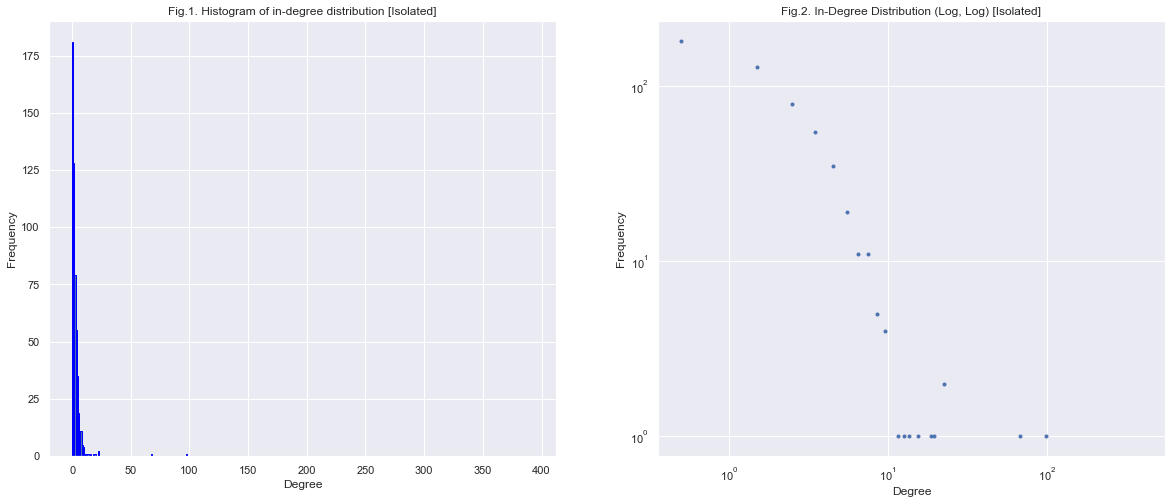

In [117]:
#Plot degree distribution 
plot_degree_distribution(in_deg, "Fig.1. Histogram of in-degree distribution [Isolated]", 
                        "Fig.2. In-Degree Distribution (Log, Log) [Isolated]")

The lin-lin and log-og in-degree distribution are shown in Figures 1 and 2 above. The histogram in Fig. 1 indicates that the in-degrees follow the power-law distribution. We notice that there are many nodes with only a few links (high frequency) and a few hubs (high degree) with large number of links. The linear dependence in the log-log plot in Fig. 2 supports the idea that indeed, the graph follows the power distribution.

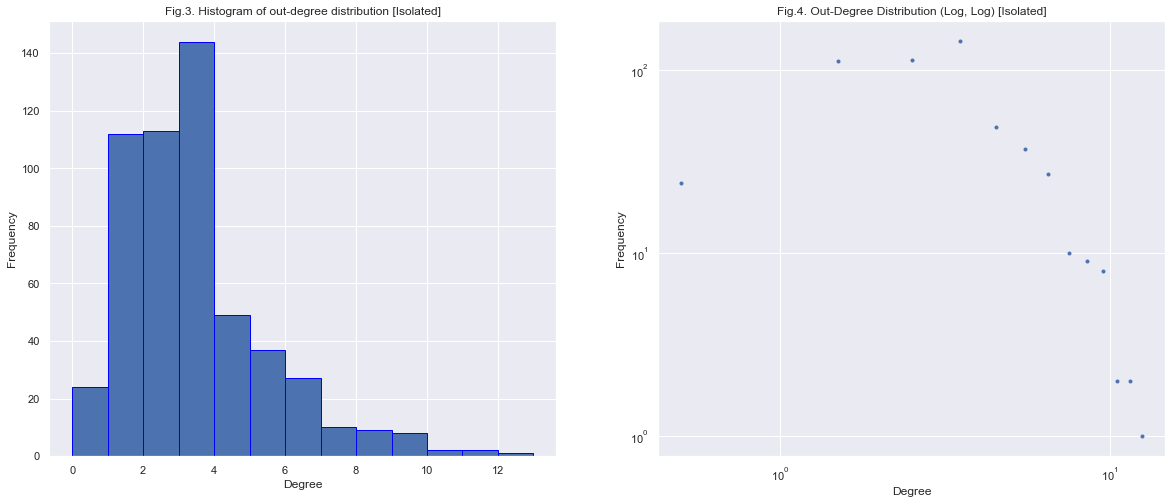

In [118]:
#Plot degree distribution 
plot_degree_distribution(out_deg, "Fig.3. Histogram of out-degree distribution [Isolated]", 
                        "Fig.4. Out-Degree Distribution (Log, Log) [Isolated]")

The lin-lin and log-log out-degree distributions are shown in Figures 3 and 4 above. The histogram in Fig. 1 indicates that the out-degrees follows a distribution which resembles the Poisson distribution (similar, but not perfectly Poisson). The histogram in Fig. 3 indicates that some of the nodes have more or less the same number of links and that overall, we do not have many highly connected nodes. The log-log plot in Fig. 4 supports the idea that indeed, the graph follows a Poisson distribution.

>   **Can you explain why the in-degree distribution is different from the out-degree distribution?**

If we are to compare the in and out-degree distributions, there are a few differences to point out:
<ol> 
    <li>The in-degrees follow the power-law distribution, which places it in the scale-free regime, whereas the out-degrees follow a somewhat Poisson distribution, which indicates that the out-degrees form a more radomized network.
    <li>Unlike the in-degrees, where most nodes have only a few links, out-degree nodes have comparable degrees and nodes with a large number of links are absent. This explains why the maximum frequency in Figure 1 spikes at 180, while the maximum frequency in Figure 3 is around 140.
</ol>

> **Find the exponent of the degree distribution (by using the `powerlaw` package) for the in- and out-degree distribution. What does it say about our network?**

In [119]:
#Function which finds the degree values of a graph based on the values of a dataframe
def degree_values(dataframe, graph, direction:str=None, allies:bool=None, gender:str=None):
    ddf = dataframe
    
    if allies is not None:
        if allies is True:
            ddf = ddf[ddf["type"] == "Ally"]
        else:
            ddf = ddf[ddf["type"] != "Ally"]
    if gender is not None:
        ddf = ddf[ddf["Gender"] == gender]
    if direction is not None:
        if direction == "out":
            return [v for k, v in graph.out_degree if k in set(ddf["Name"])]
        else:
            return [v for k, v in graph.in_degree if k in set(ddf["Name"])]
    else:
        return [v for k, v in graph.to_undirected().degree if k in set(ddf["Name"])]

In [181]:
#Use powerlaw.Fit(degree).alpha for fitting
degree_in = degree_values(df, G, direction="in")
degree_out = degree_values(df, G, direction="out")

#Find the degree exponent for in-, out- and total- degree distribution. 
fit_in = powerlaw.Fit(degree_in)
fit_out = powerlaw.Fit(degree_out)

print(f'Degree exponent for in-degree distribution: {fit_in.alpha}')
print(f'Degree exponent for out-degree distribution: {fit_out.alpha}')

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Degree exponent for in-degree distribution: 3.219946378471779
Degree exponent for out-degree distribution: 4.382534250673276


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


The degree exponent or γ varies from system to system, prompting us to explore how the properties of a network change with γ (Barabasi, Network Science, Section 4.7). A value of γ higher than 2 indicates that a network is in the random regime. With a degree exponent for in-degree distribution is 3.22, and a degree exponent for out-degree distribution is 4.38, this is telling us that out-degree distribution has a higher degree of randomness compared to the in-degree distribution. Also, the degree exponent of the in-degree distribution is only slightly above 3, indicating that it can be placed closer to the scale-free regime.

Moreover, the degree exponent is an important indicator for the maximum degree of a scale-free network, which applies to the in-degree network. The equation below predicts that $k_{max}$ of the in-degree grows with the size of the network with exponent $1/(\gamma - 1)$:

$$k_{max}=k_{min}N^{\frac{1}{γ−1}}      $$ 

For $N=539$, and an exponent $1/(\gamma - 1) \approx 0.5$ , $k_{max}$ is close to 23, which is reflected in Fig. 1 on the y-axis. This does not hold true for the out-degree network, which is closer to a random network than it is to a scale-free network.

> **Compare the degree distribution of the undirected graph to a *random network* with the same number of nodes and probability of connection *p*. Comment your results.**

In [95]:
#Create random network with the same number of nodes and same probability as the undirected graph
nodes = len(df)
degrees = [v for k, v in dict(G.degree).items()]
p = np.mean(degrees)/(nodes-1)
G_RN = nx.erdos_renyi_graph(n=nodes, p=p)

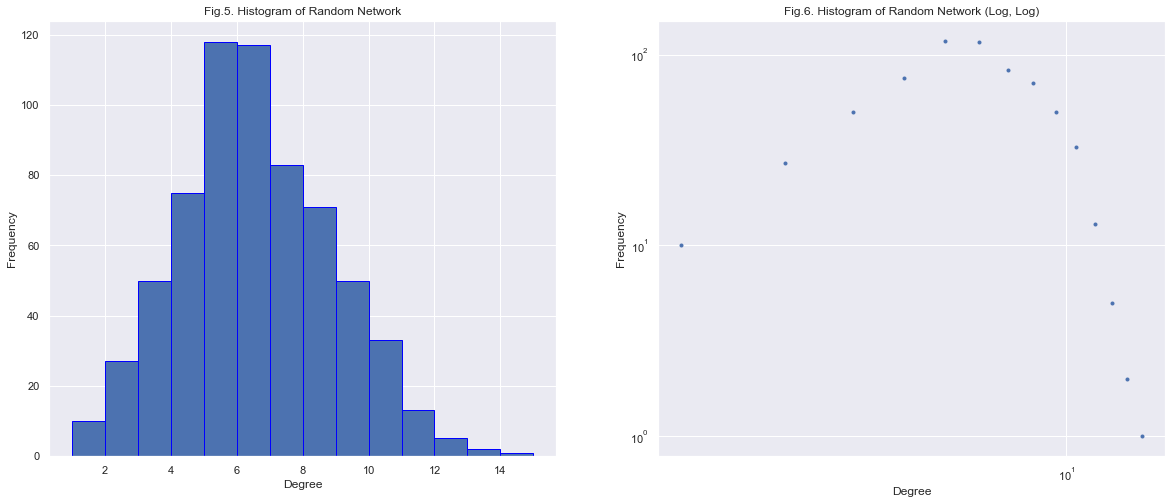

In [122]:
deg = [v for k, v in dict(G_RN.degree).items()]
plot_degree_distribution(deg, "Fig.5. Histogram of Random Network", 
                        "Fig.6. Histogram of Random Network (Log, Log)")

Figures 5 and 6 describe the degree distributions of a random network with $N=539$ nodes and a probability $p=0.009$. The distributiton in Fig. 5 follows a Poisson distribution, which is confirmed by the log-log plot in Figure 6. Unlike the out-degree distributions in Fig. 3 and 4, the random network fits the Poisson distribution perfectly. We can notice that the majority of nodes have the same number of links, more than in the distribution in Fig. 3. Similarly, both in Figure 3 and Figure 5, there are only a few highly connected nodes. 

_Exercise 1b_: Visualization (see lecture 5 for more hints)

> * Create a nice visualization of the total (undirected) network:
>   * Color nodes according to the role;
>   * Scale node-size according to degree;
>   * Get node positions based on the Force Atlas 2 algorithm;
>   * Whatever else you feel like that would make the visualization nicer.
> * Describe the structure you observe. Can you identify nodes with a privileged position in the network? Do you observe chains of connected nodes? Do you see any interesting group of nodes (can you guess who's involved)?

#### Create a nice visualization of the total (undirected) network:
>   * Color nodes according to the role;
>   * Scale node-size according to degree;
>   * Get node positions based on the Force Atlas 2 algorithm;
>   * Whatever else you feel like that would make the visualization nicer.

In [126]:
#function which maps role to color
def role_to_color(role):
    if role =='Ally':
        return "green"
    elif role =='Enemy':
        return "blue"
    elif role =='Boss':
        return "red"
   

In [131]:
#function which scales the nodes according to degree 
def node_degree_to_size(degree):
    return degree ** 1.5

In [172]:
#function which assigns a label to nodes with a specific degree
def node_degree_to_label(degree):
    return degree > 17

In [329]:
#list of roles
role = nx.get_node_attributes(G_undirected, 'Role')
#list of colors
#Nodes are colored according to the role
role_color = [role_to_color(r) for r in role.values()]
#list of node sizes
node_size = [node_degree_to_size(d) for k, d in dict(G_undirected.degree).items()]
#list of node labels
node_label = {k:k for k, d in dict(G_undirected.degree).items() if node_degree_to_label(d)}

In [174]:
# plt.rcParams['figure.figsize'] = [15, 10]

# fig,ax = plt.subplots(1,figsize=(14,12))
# nx.draw_kamada_kawai(G_undirected, nodelist=[v for v in dict(G_undirected.degree).keys()], 
#                      node_size=[v*2 for v in dict(G_undirected.degree).values()], node_color=role_color, ax=ax, width=0.5)

In [179]:
#function which plots the visualization of the total (undirected) network using the Force Atlas 2 algorithm
def plot_with_fa(graph, _node_colors, _node_size, _node_label):
    plt.rcParams['figure.figsize'] = [20, 15]
    forceatlas2 = ForceAtlas2(
                            # Behavior alternatives
                            outboundAttractionDistribution=True,  # Dissuade hubs
                            edgeWeightInfluence=1.0,

                            # Performance
                            jitterTolerance=7,  # Tolerance
                            barnesHutOptimize=True,
                            barnesHutTheta=1.6,

                            # Tuning
                            scalingRatio=2.0,
                            strongGravityMode=False,
                            gravity=15.0,

                            # Log
                            verbose=True)

    #node positions based on the Force Atlas 2 algorithm 
    positions = forceatlas2.forceatlas2_networkx_layout(graph, pos=None, iterations=4000)
    #draw nodes
    nx.draw_networkx_nodes(graph, positions, alpha=1, node_color=_node_colors, node_size=_node_size)
    #draw edges
    nx.draw_networkx_edges(graph, positions, edge_color=_node_colors, alpha=0.15)
    #draw labels
    nx.draw_networkx_labels(graph,positions, _node_label, font_size=10, font_color='black')
    #hide axis
    plt.title("Fig. 7. Visualization of the Total Undirected Network")
    plt.axis('off')
    plt.show()


100%|███████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:14<00:00, 273.11it/s]


BarnesHut Approximation  took  5.12  seconds
Repulsion forces  took  7.50  seconds
Gravitational forces  took  0.17  seconds
Attraction forces  took  0.09  seconds
AdjustSpeedAndApplyForces step  took  0.67  seconds


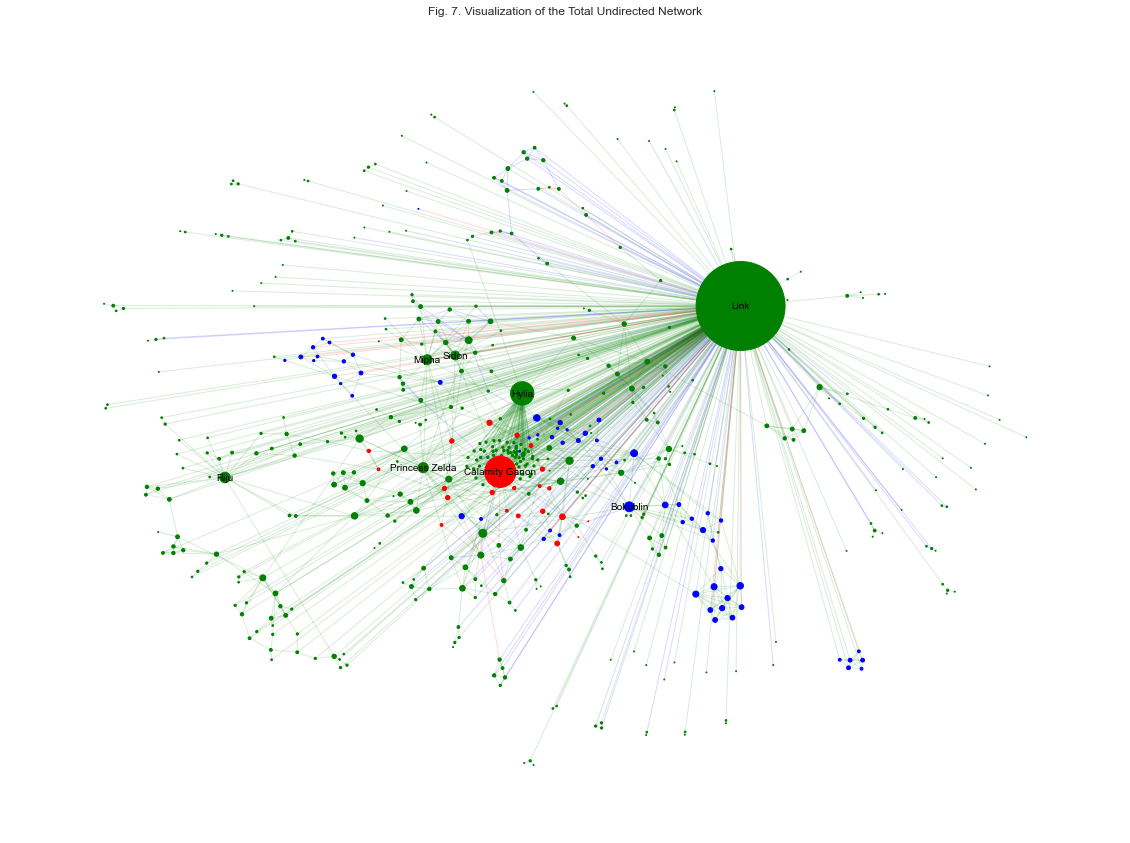

In [180]:
plot_with_fa(G_undirected, role_color, node_size, node_label)

Figure 7 above provides the visualization of the whole undirected graph G with 539 nodes and 1595 links. The nodes and the edges colors were colored based on the role attribute (green for allies, blue for ennemies, red for bosses), and the node size was scaled based on the node degree. 

> **Describe the structure you observe. Can you identify nodes with a privileged position in the network? Do you observe chains of connected nodes? Do you see any interesting group of nodes (can you guess who's involved)?|**

We can notice from Figure 7 that there are 3 central nodes with a privileged position in the network. These are 
Link, which was the top connected node (Ally, 394 links), Calamity Ganon (Boss, 97 links), and Hylia (Ally, 67 links). These three nodes have the highest degree centrality which scales us proportionally with their degree. At the same time, these nodes have a high rank of eigenvector centrality (0.48, 0.14 and 0.26 respectively), which is based on the principle that connections to high-scoring nodes contribute more to the score of the node in question than equal connections to high-scoring nodes. Moreover, Link and Hylia have a high out-degree, whereas Calamity Ganon displays a high in-degree. These arguments justify why the nodes are in a privileged position.

In [202]:
print(f'Eigenvector centrality Link: {nx.eigenvector_centrality(G)["Link"]}')
print(f'Eigenvector centrality Link: {nx.eigenvector_centrality(G)["Hylia"]}')
print(f'Eigenvector centrality Link: {nx.eigenvector_centrality(G)["Calamity Ganon"]}')
# print(f'In-degree Link: {dict(G.out_degree)["Link"]}')
# print(f'In-degree Hylia: {dict(G.out_degree)["Hylia"]}')
# print(f'In-degree Calamity Ganon: {dict(G.in_degree)["Calamity Ganon"]}')

Eigenvector centrality Link: 0.4871249600097877
Eigenvector centrality Link: 0.14622654452131556
Eigenvector centrality Link: 0.25536161808316726


Also, from the figure above, we can notice that there are a few chains of connected nodes, especially chains of allies and of ennemies. If we follow the blue and green nodes, we notice that most of the these chains of nodes have edges of the same color, indicating that characters have more links with other characters sharing the same role.

In terms of node size, we can notice that the smaller nodes tend to cluster around the bigger nodes. Some of the most interesting clusters are formed around Link, Calamity Ganon, Hylia, Princess Zelda, Riju, Sidon, Mipha and Bokoblin. In the Zelda universe, these are characters playing a central role in the main plot, being either friends of the main character (Sidon) or chiefs (Riju) or very common ennemies (Bokoblin) or major antagonists (Calamity Ganon), which explains why they are interconnected with the other characters. 

<!-- Node centrality 
1) degree centrality - perfectly correlated with the degree 
2) closeness centrality  = mean distance between a vertex and all the other vertices reachable from it (shortest path) - not perfectly correlated with a degree
3) betweenness - vertices that occur on many shortest paths between other vertices have higher betweenness than those that don't 
4) eigenvector centrality - measure of the importance of a node in a network; it assigns relative scores to all nodes in a network based on the principle that connections to high-scoring nodes contribute more to the score of the node in question than equal connections to high-schoring nodes -->

# Part 2: Word-clouds

Create your own version of the word-clouds (from lecture 7). For this exercise we assume you know how to download and clean text from the ZeldaWiki pages.

Here's what you need to do:
> * Create a word-cloud for each race of the [five champions of Hyrule](https://zelda.fandom.com/wiki/Champions) (i.e. Hylian, Zora, Goron, Gerudo, and Rito) according to either TC-IDF. Feel free to make it as fancy as you like. Explain your process and comment on your results.

In [426]:
#Please explain how we got this folders
path_ftxts = "preprocessed_texts/"

# save list of characters
characters = list(df['Name'])
unique_races = df.Race.unique()

preprocessed_tokens = []
# Fill dict of communities with a long list of all words for each community, taken from the words in their characters wikis
for char in characters:
    with open(path_ftxts+char.replace(" ","_")+".txt") as x:
        temp = json.load(x)
        preprocessed_tokens += temp
text_all = nltk.Text(preprocessed_tokens)

In [359]:
#Calculate TFIDF for all races
#Make a dict of races
text_races = {race:[] for race in unique_races}
# Fill dict of races with a long list of all words in each wiki for every character in a race
for char in characters:
    with open(path_ftxts+char.replace(" ","_")+".txt") as x:
        text_races[df[df.Name == char]["Race"].item()] += json.load(x)
        
# Find Term Frequency (TF) for every word within each race (local search) #
TF_races = {race:[] for race in unique_races}
for race in unique_races:
    # normalize output from FreqDist
    race_to_TF = {node:count/len(text_races[race]) for node,count in FreqDist(text_races[race]).items()}
    # sort by descending values
    TF_races[race] += sorted(race_to_TF.items(), key=lambda x: x[1], reverse=True)
    TF_races[race] = dict(TF_races[race])

# Find Inverse Document Frequency (IDF) #
# number of documents N=|D|. D is the races!
numdocs = len(unique_races)
# number of documents where term t appears |{d \in D: t \in d}|
numdocs_tinD = {word:len([word for race in unique_races if word in text_races[race]]) for word in tqdm(set(text_all))}
IDF_races = {word:math.log(numdocs/numdocs_tinD[word]) for word in set(text_all)}

# calculate TFIDF for each word in each race. So a dict of races, where each element is a dict of words and their TFIDF values
TFIDF_races = {race:{word:TF_races[race][word]*IDF_races[word] for word in set(text_races[race])} for race in unique_races}

# Get TCIDF from TFIDF by un-normalizing the TF
TCIDF_races = {race:{word:tf_idf*len(text_races[race]) for word,tf_idf in race_dict.items()} for race,race_dict in TFIDF_races.items()}

  0%|          | 0/7412 [00:00<?, ?it/s]

In [437]:
## Function to plot the wordclouds for the inputs in a given category. Also preps data for the WordCloud() function ##
def plot_wordclouds(Category,TCIDF,unique_races,mask=None):
    # prepare text by category for the wordcloud function. Add each word a number of times according to their TC-IDF scores
    onestring_races = {race:"" for race in unique_races}
    for race in unique_races:
        for word in TCIDF[race]:
            for _ in range(round(TCIDF[race][word])):
                onestring_races[race] += word+" "
        # Generate wordcloud object to be plotted
        wc = WordCloud(width=1500,height=750,collocations=False,background_color='white',mask=mask).generate(onestring_races[race])
        # plot each wordcloud
        plt.figure(figsize=(10,8))
        plt.imshow(wc,interpolation="bilinear")
        plt.axis('off')
        plt.title(f'{Category}: {race}', fontdict = {'fontsize' : 20})
        plt.show()

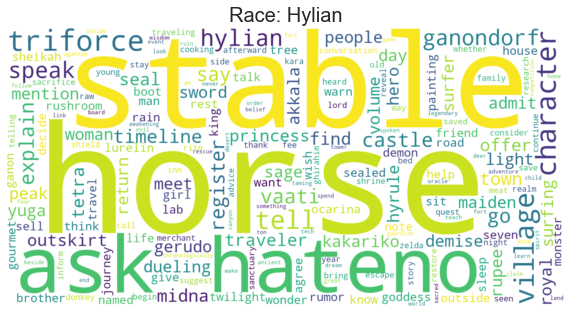

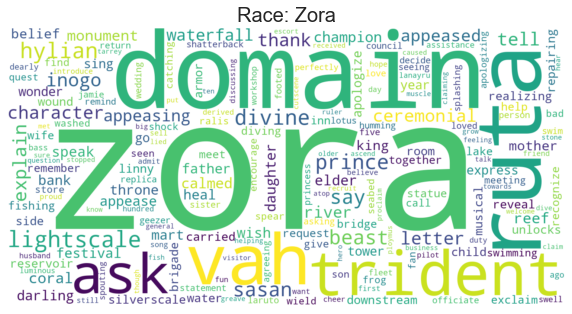

In [ ]:
# plot the wordclouds for the races of the 5 champions
unique_races_champions = ['Hylian', 'Zora', 'Goron', 'Gerudo', 'Rito']
plot_wordclouds("Race",TCIDF_races,unique_races_champions)

# Part 3: Communities and TF-IDF

Find communities and compute their associated TF-IDF (from lecture 7 and 8).

Here's what you need to do:
> * Explain the Louvain algorithm and how it finds communities in a newtork.
> * Explain how you chose to identify the communities: Which algorithm did you use? (if you did not use the Louvain method, explain how the method you have used works) 
> * Comment your results:
>   * How many communities did you find in total?
>   * Compute the value of modularity with the partition created by the algorithm.
>   * Plot the distribution of community sizes.
> * For the 5 largest communities, create TF-IDF based rankings of words in each community. 
>   * There are many ways to calculate TF-IDF, explain how you've done it and motivate your choices.
>   * List the 5 top words for each community according to TF.
>   * List the 5 top words for each community accourding to TF-IDF. Are these words more descriptive of the community than just the TF? Justify your answer.

> * **Explain the Louvain algorithm and how it finds communities in a newtork.**
>
> The louvain algorithm is unsupervised, meaning that it doesn't require you to define the size or number of communities beforehand. It is split up into 2 parts: Modularity optimization and community aggregation [1], which are repeated iteratively until no further improvement in modularity can be achieved.
>
> Phase 1:
> * Starting with modularity optimization, the algorithm starts with a weighted network of $N$ nodes, and assigns a different community to every single node, meaning there will be as many communities as nodes.
> * For every node $i$, we consider the neighbouring nodes $j$ of $i$, and calculate the gain in modularity from removing $i$ from its current community and placing it into the community of $j$. This is done via the following formula.
> $$\Delta Q = \left[\frac{\sum_{in}+2k_{i,in}}{2m}-\left(\frac{\sum_{tot}+k_i}{2m}\right)^2 \right] - \left[\frac{\sum_{in}}{2m}-\left(\frac{\sum_{tot}}{2m}\right)^2-\left(\frac{k_i}{2m}\right)^2\right]$$
> Here $\Delta Q$ is the gain in modularity obtained by moving node $i$ into community $C$, $\sum_{in}$ is the sum of the weights of the links inside $C$, $\sum_{tot}$ is the sum of the weights of the links incident to nodes in $C$, $k_{i}$ is the sum of the weights of the links incident to $i$, $k_{i,in}$ is the sum of the weights of the links from $i$ to nodes in $C$ and $m$ is the sum of the weights of all the links in the network. The node $i$ is then moved into the neighbouring community which gives the maximum $\Delta Q$, if a positive one exists. Else it remains in it's current community. This process is continued until no further improvements in modularity are possible. This phase only allows for local changes in communities.
>
> Phase 2:
> In the next phase a new network of nodes is built using the communities found in phase 1.
>
> These two phases are repreated iteratively until no further improvement in modularity can be achieved, whereafter the algorithm stops.

> * **Explain how you chose to identify the communities: Which algorithm did you use? (if you did not use the Louvain method, explain how the method you have used works)**
>
> We chose to use the louvain algorithm for community detection. See above for a detailed description of the algorithm.

> **Reference**
>
> [1] V. D. Blondel, J.-L. Guillaume, R. Lambiotte and E. Lefebvre, "Fast unfolding of communities in large networks," J. Stat. Mech. (2008) P10008, p. 12, 2008.

> * **Comment your results:**
>   * **How many communities did you find in total?**
>   * **Compute the value of modularity with the partition created by the algorithm.**

In [335]:
# read saved DiGraph from path
# path_lectures = 'C:/Users/Nikolaj/OneDrive - Danmarks Tekniske Universitet/DTU/Kandidat/3. semester/Social Graphs and Interactions/socialgraphs2021/lectures/'
# G = nx.read_gpickle(path_lectures+'ZeldaNetwork.gpickle')
# convert Digraph to undirected graph
#G_u = G.to_undirected()

partition = community_louvain.best_partition(G_undirected)
#unique_coms = set(partition.values())
print(f'Number of communities: {len(set(partition.values()))}')
communities_louvain = [[node for node in partition if partition[node] == cat] for cat in set(partition.values())]


Number of communities: 21


In [337]:
modularity_louvain = nx.algorithms.community.modularity(G_undirected,communities_louvain)
print(f'Modularity for communities by louvain-algorithm: {modularity_louvain}')

Modularity for communities by louvain-algorithm: 0.5950941693204427


>   * **Plot the distribution of community sizes.**

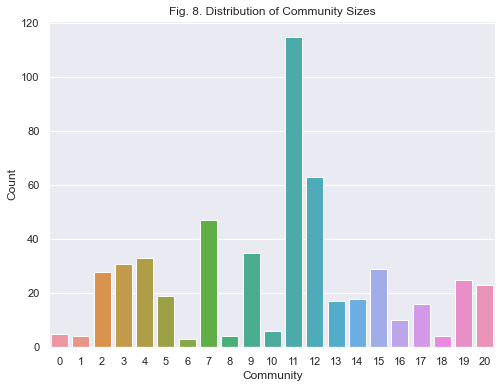

In [391]:
# Plot the distribution of community sizes
com_sizes = FreqDist(partition.values())
x = [com for com in com_sizes.keys()]
y = [size for size in com_sizes.values()]
fig,ax = plt.subplots(figsize=(8,6))
sns.barplot(x=x,y=y)
plt.rcParams["figure.figsize"] = (10,8)
plt.xlabel('Community')
plt.ylabel('Count')
plt.title('Fig. 8. Distribution of Community Sizes')
plt.show()

> Figure text: Distribution of the community sizes found by the louvain algorithm. The $x$-axis gives the different communities and the $y$-axis gives the number of nodes in a community. We can see that the majority of characters have been placed in community 5. There is also a large amount in communities 3, 6 and 12. As the louvain algorithm has stochastic elements, the communities change everytime we calculate them.

> * **For the 5 largest communities, create TF-IDF based rankings of words in each community.**
>   * **There are many ways to calculate TF-IDF, explain how you've done it and motivate your choices.**

> We calculate TF-IDF via the following. First we find the term frequency of each term $t$ in each community $d$ with
>
> $$\text{tf}(t,d) = \frac{f_{t,d}}{\sum_{t'\in d} f_{t',d}},$$
> 
> where $f_{t,d}$ is the number of times that term $t$ appears in community $d$ and $\sum_{t'\in d} f_{t',d}$ is the number of unique terms in a community. Next we calculate the inverse document frequency of term $t$ in the set of communities $D$ with
>
> $$\text{idf}(t,D) = \log\left(\frac{N}{|\{d\in D: t\in D\}|}\right),$$
>
> where $N$ is the total number of communities and $|\{d\in D: t\in D\}|$ is the number of communities where the term $t$ appears. Finally we calculate the TF-IDF values of every term $t$ in every community $d$ given a set of communities $D$ with
>
> $$\text{tfidf}(t,d,D) = \text{tf}(t,d)\cdot\text{idf}(t,D).$$

In [371]:
unique_coms = [com for com,_ in sorted(com_sizes.items(), key=lambda x: x[1], reverse=True)[:5]]
print(f'5 largest communities: {unique_coms}')

5 largest communities: [11, 12, 7, 9, 4]


In [362]:
### Calculate TFIDF for each community ###

# save list of characters according to graph and top 5 communities
characters = [x for x in partition.keys() if partition[x] in unique_coms]
# make new list of preprocessed_tokens from nodes (characters) in partition
preprocessed_tokens = []
# Make a dict of communities
text_coms = {com:[] for com in unique_coms}
# Fill dict of communities with a long list of all words for each community, taken from the words in their characters wikis
for char in characters:
    with open(path_ftxts+char.replace(" ","_")+".txt") as x:
        temp = json.load(x)
        text_coms[partition[char]] += temp
        preprocessed_tokens += temp
text_all_coms = nltk.Text(preprocessed_tokens)
# Find term frequency (TF) for each word within each community (local search)
TF_coms = {com:[] for com in unique_coms}
for com in unique_coms:
    # normalize
    com_to_tf = {node: count /len(text_coms[com]) for node, count in FreqDist(text_coms[com]).items()}
    # sort the result
    TF_coms[com] += sorted(com_to_tf.items(), key=lambda x: x[1], reverse=True)
    TF_coms[com] = dict(TF_coms[com])

# Find Inverse Document Frequency (IDF) #
# number of documents N=|D|. D is the communities!
numdocs = len(unique_coms)
# number of documents where term t appears (adjusted with +1 t avoid division by zero) |{d \in D: t \in d}|
numdocs_tinD = {word:len([word for com in unique_coms if word in text_coms[com]]) for word in tqdm(set(text_all_coms))}
# IDF = log(N/|{d \in D: t \in D}|)
IDF_coms = {word:math.log(numdocs/numdocs_tinD[word]) for word in set(text_all_coms)}

# calculate TFIDF for each community and each word in each community
TFIDF_coms = {com:{word:TF_coms[com][word]*IDF_coms[word] for word in set(text_coms[com])} for com in unique_coms}

  0%|          | 0/5716 [00:00<?, ?it/s]

>   * **List the 5 top words for each community according to TF.**

In [370]:
# Find top 5 term for each of the top 5 communities
top5terms = {com:sorted(TF_coms[com].items(),key=lambda x: x[1],reverse=True)[:5] for com in unique_coms}
print(f'Top 5 terms for all commmunities by Term Frequency (word, TF):\n')
for com in unique_coms:
    print(f'Community {com}: {[(word,round(val,4)) for word,val in top5terms[com]]}')

Top 5 terms for all commmunities by Term Frequency (word, TF):

Community 11: [('gerudo', 0.0152), ('wild', 0.0093), ('character', 0.008), ('breath', 0.008), ('tell', 0.0077)]
Community 12: [('shrine', 0.0809), ('monk', 0.0497), ('sheikah', 0.0417), ('breath', 0.0226), ('wild', 0.0226)]
Community 7: [('zelda', 0.0195), ('hyrule', 0.0095), ('time', 0.0083), ('sheikah', 0.0066), ('village', 0.0065)]
Community 9: [('gerudo', 0.0327), ('town', 0.0157), ('say', 0.0111), ('speaks', 0.0109), ('tell', 0.0107)]
Community 4: [('moblins', 0.0115), ('bokoblins', 0.011), ('attack', 0.0087), ('sword', 0.0085), ('also', 0.0083)]


>   * **List the 5 top words for each community accourding to TF-IDF. Are these words more descriptive of the community than just the TF? Justify your answer.**

In [364]:
# Find top 5 TFIDF value words for each of the top 5 communities
top5_tfidf_coms = {com:sorted(TFIDF_coms[com].items(), key=lambda x: x[1],reverse=True)[:5] for com in unique_coms}
print(f'Top 5 TF-IDF value words for each community (word, TF-IDF score):\n')
for com in unique_coms:
    print(f'Community {com}: {[(word,round(tf_idf,4)) for word,tf_idf in top5_tfidf_coms[com]]}')

Top 5 TF-IDF value words for each community (word, TF-IDF score):

Community 11: [('gerudo', 0.0034), ('sand', 0.0019), ('kara', 0.0018), ('rito', 0.0018), ('town', 0.0017)]
Community 12: [('monk', 0.0456), ('entered', 0.0175), ('ostracism', 0.0175), ('greeted', 0.01), ('activated', 0.01)]
Community 7: [('timeline', 0.003), ('pumpkin', 0.002), ('triforce', 0.0015), ('fortified', 0.0015), ('heirloom', 0.0015)]
Community 9: [('gerudo', 0.0073), ('barrack', 0.0063), ('volume', 0.005), ('helm', 0.0044), ('thunder', 0.0044)]
Community 4: [('moblins', 0.0186), ('lynels', 0.0073), ('variant', 0.0057), ('bokoblins', 0.0056), ('stronger', 0.0037)]


>It can be seen when comparing the top words found with TF-IDF to the top words found with TF alone, that the words found with TF include quite a few non-descriptive words, such as "say", "tell" and "also". These words do not represent the characters in the communities, as they are just filler words, not differentiating the characters in one community from another.
>
>We can also see that the TF-IDF score is more descriptive than the TF alone by looking at the definition of both (see definition above). While the TF only looks at the number of times a term appears in a community,  the TF-IDF also weights this by the IDF, which is a measure of how much information the term provides to the community. So the IDF will be higher if the the term is rare across the different communities. This means the TF-IDF will be highest when a term is very frequent in a community and shows up in that community only. This further highlights why the TF-IDF score gives words that are more descriptive than when only using the TF.

# Part 4: Sentiment of communities

Analyze the sentiment of the communities (lecture 8). Here, we assume that you've successfully identified communities.  More tips & tricks can be found, if you take a look at Lecture 8's exercises.

A couple of additional instructions you will need below:
* We name each community by its three most connected characters.
* Average the average sentiment of the nodes in each community to find a community level sentiment.

Here's what you need to do (repeat these steps and report your results for **both LabMT and VADER**):
> * Calculate and store sentiment for every character
> * Create a histogram of all character's associated sentiments.
> * What are the 10 characters with happiest and saddest pages?

Now, compute the sentiment of communities: 
> * What are the three happiest communities according to the LabMT wordlist approach? What about VADER?
> * What are the three saddest communities according to the LabMT wordlist approach? What about VADER?
> * Create a bar plot showing the average sentiment of each community and add error-bars using the standard deviation for both methods. 
> * Explain the difference between the two methods and compare the results you have obtained above.
> * What is the advantage of using a rule-based method over the dictionary-based approach? 

In [365]:
# Load word sentiment dataset
df_sentiment = pd.read_csv(Path("Data_Set_S1.txt"), sep="	")
df_sentiment.head()[["word", "happiness_average"]]

,word,happiness_average
0,laughter,8.50
1,happiness,8.44
2,love,8.42
3,happy,8.30
4,laughed,8.26


In [372]:
dialogues_url = "https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2021/main/files/CharactersDialogue.json"
r = requests.get(dialogues_url)
character_to_dialogues = r.json()

df_gcc = df[df["Name"].apply(lambda name: name in G.nodes)].reset_index(drop=True)
df_gcc_dialogues = df_gcc[df_gcc["Name"].apply(lambda name: name in character_to_dialogues)].reset_index(drop=True)
df_gcc_dialogues["dialogues"] = df_gcc_dialogues["Name"].apply(lambda name: character_to_dialogues[name])

f"Out of {len(df_gcc)} characters in the greatest component subgraph, we analyze {len(df_gcc_dialogues)} found in dialogues.", 

('Out of 546 characters in the greatest component subgraph, we analyze 440 found in dialogues.',)

**A couple of additional instructions you will need below:**
* **We name each community by its three most connected characters.**

In [373]:
G_undirected = G.to_undirected()
node_to_partition_id = community_louvain.best_partition(G_undirected)

In [374]:
def partition_to_top3_names(G, node_to_partition_id, partition_id):
    nodes_in_partition = [node for node in G.nodes() 
                          if node_to_partition_id[node] == partition_id]
    sub_G = G.subgraph(nodes_in_partition)
    node_to_connectivity = [(node, sub_G.degree(node)) for node in sub_G.nodes()]
    top3_nodes = sorted(node_to_connectivity, key=lambda t: t[1], reverse=True)[:3]
    return ", ".join([n for n, _ in top3_nodes])
    
partition_id_to_name = {partition_id: partition_to_top3_names(G_undirected, node_to_partition_id, partition_id) 
                        for partition_id in set(node_to_partition_id.values())}


In [375]:
# Assign community it to each character row in df_gcc
df_gcc_dialogues["community"] = df_gcc["Name"].apply(lambda name: partition_id_to_name[node_to_partition_id[name]])
df_gcc_dialogues.head()

,Name,Role,Race,Gender,dialogues,community
0,Baddek,Ally,Hylian,Male,"[That bony horse ran really well, and it was a...","Baddek, Nazbi, Dauntless"
1,Banji,Ally,Hylian,Female,"[If you ask me, it's a sign from Hylia herself...","Baumar, Falmark, Selmie"
2,Baumar,Ally,Hylian,Male,[Riding a horse up a hill and then hopping off...,"Banji, Epona, Dabi"
3,Bayge,Ally,Goron,Male,"[}ࠀPUMP IT UP, BROTHER!ȁdAren't ya forgettin' ...","Baumar, Falmark, Selmie"
4,Beedle,Ally,Human,Male,"[Get back!, ଐMaybe you should take those cloth...","Bludo, Greyson, Pelison"


* **Average the average sentiment of the nodes in each community to find a community level sentiment.**

In [376]:
wordnet_lemmatizer = WordNetLemmatizer()
punctuations = "?:!.,;"

def preprocess(sentences: List[str]) -> List[str]: # List of sentences to lists of processed words
    sentences = " ".join(sentences)
    sentence_words = nltk.word_tokenize(sentences)
    words_lemmatized = [wordnet_lemmatizer.lemmatize(w, pos='v').lower() 
                        for w in sentence_words 
                        if w not in punctuations]
    return words_lemmatized
preprocess(["He is running very fast!", "That's impressive"])

['he', 'be', 'run', 'very', 'fast', 'that', "'s", 'impressive']

In [377]:
df_gcc_dialogues["words"] = df_gcc_dialogues["dialogues"].apply(preprocess)
df_gcc_dialogues[["dialogues", "words"]].head(2)

,dialogues,words
0,"[That bony horse ran really well, and it was a...","[that, bony, horse, run, really, well, and, it..."
1,"[If you ask me, it's a sign from Hylia herself...","[if, you, ask, me, it, 's, a, sign, from, hyli..."


In [378]:
def compute_sentiment_LabMT(words):
    """
    In this function we use inner join between words from the text we analyze and the words in the 
    word sentiment dataframe. This results in a matching each word to its sentiment score.
    
    Keep in mind, that words with no assigned sentiment value will not be considered.
    """
    words_series = pd.Series(words).rename('word')
    sentiments = df_sentiment.merge(words_series, how='inner', on="word")
    return sentiments["happiness_average"].mean()
    
(compute_sentiment_LabMT(preprocess(["I am incredibly happy to be here, my dear"])),
 compute_sentiment_LabMT(preprocess(["You are the worst"]))) # TODO: print

(6.184444444444444, 4.75)

**Here's what you need to do (repeat these steps and report your results for **both LabMT and VADER**):**
> * **Calculate and store sentiment for every character**

In [382]:
df_gcc_dialogues["sentiment_LabMT"] = df_gcc_dialogues["words"].apply(compute_sentiment_LabMT)


In [383]:
analyzer = SentimentIntensityAnalyzer()

def compute_sentiment_VADER(dialogues):
    return np.mean([analyzer.polarity_scores(sentence)['compound'] for sentence in dialogues])
df_gcc_dialogues["sentiment_VADER"] = df_gcc_dialogues["dialogues"].apply(compute_sentiment_VADER)

In [384]:
community_to_avg_sentiments = [{"community": community,
                                "avg VADER sentiment": round(df_comm["sentiment_VADER"].mean(), 3),
                                "avg LabMT sentiment": round(df_comm["sentiment_LabMT"].mean(), 3) }   
                                for community, df_comm 
                                in df_gcc_dialogues.groupby("community")]

pd.DataFrame(community_to_avg_sentiments)

,community,avg VADER sentiment,avg LabMT sentiment
0,"Akrah, Garshon, Onya",0.312,5.666
1,"Ami, Yolero, Izra",0.123,5.561
2,"Ashai, Pearle, Makure",0.141,5.493
3,"Azu, Amira, Nikki",0.207,5.588
4,"Baddek, Nazbi, Dauntless",0.321,5.566
5,"Banji, Epona, Dabi",0.160,5.516
6,"Baumar, Falmark, Selmie",0.323,5.525
7,"Bladon, Gonguron",0.127,5.405
8,"Bludo, Greyson, Pelison",0.212,5.532
9,"Bokoblin, Moblin, Blue Bokoblin",0.225,5.512


> * **Create a histogram of all character's associated sentiments.**

Text(0.5, 1.0, "Fig. 9. Histogram of All Character's Associated Sentiments (VADER)")

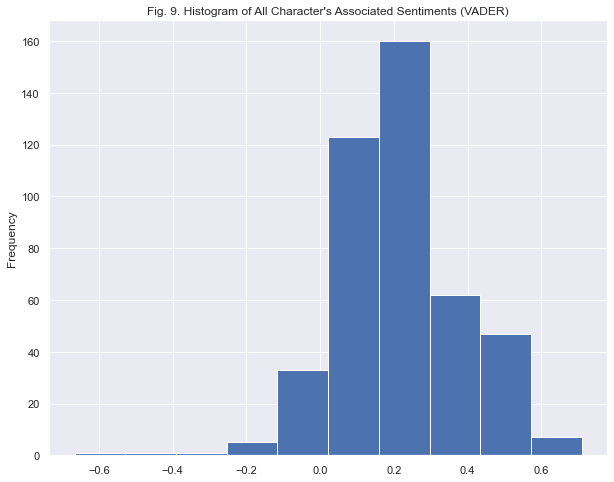

In [395]:
df_gcc_dialogues["sentiment_VADER"].plot.hist()
plt.rcParams["figure.figsize"] = (10,8)
plt.title("Fig. 9. Histogram of All Character's Associated Sentiments (VADER)")

<AxesSubplot:title={'center':"Fig. 10. Histogram of All Character's Associated Sentiments (LabMT)"}, ylabel='Frequency'>

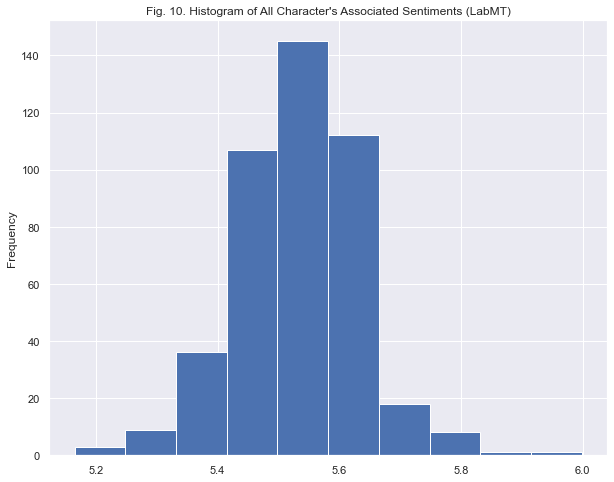

In [396]:
plt.rcParams["figure.figsize"] = (10,8)
plt.title("Fig. 10. Histogram of All Character's Associated Sentiments (LabMT)")
df_gcc_dialogues["sentiment_LabMT"].plot.hist()

> * **What are the 10 characters with happiest and saddest pages?**

In [397]:
pd.options.display.max_colwidth = 150
df_gcc_dialogues.nlargest(10, "sentiment_VADER")[["Name",  "sentiment_VADER"]]

,Name,sentiment_VADER
84,Canni,0.709950
106,Breen,0.709950
41,Toren,0.649750
151,Peeks,0.632270
280,Harlow,0.630900
45,Zyle,0.614080
32,Nazbi,0.600900
400,Sebasto,0.572300
148,Kula,0.565555
3,Bayge,0.563889


In [398]:
df_gcc_dialogues.nsmallest(10, "sentiment_VADER")[["Name","sentiment_VADER"]]

,Name,sentiment_VADER
262,Palme,-0.665600
212,Kotta,-0.465670
44,Princess Zelda,-0.350122
241,Sumati,-0.164014
281,Monkton,-0.150100
256,Flaxel,-0.146783
438,Master Kohga,-0.133433
290,Kotts,-0.123611
181,Strade,-0.114608
37,Rik,-0.112700


In [399]:
df_gcc_dialogues.nlargest(10, "sentiment_LabMT")[["Name", "sentiment_LabMT"]]

,Name,sentiment_LabMT
397,Kinov,5.998571
373,Narah,5.905625
148,Kula,5.811264
41,Toren,5.800952
294,Notts,5.798402
210,Katta,5.786452
226,Olu,5.778438
299,Cecili,5.775850
394,Chessica,5.764615
124,Shamae,5.760247


In [400]:
df_gcc_dialogues.nsmallest(10, "sentiment_LabMT")[["Name","sentiment_LabMT"]]

,Name,sentiment_LabMT
67,Aya,5.165000
24,Kenyo,5.182418
212,Kotta,5.204215
126,Bargoh,5.252552
181,Strade,5.255612
256,Flaxel,5.282149
86,Dai,5.293593
182,Sudrey,5.297353
110,Drak,5.298429
262,Palme,5.301333


**Now, compute the sentiment of communities:**
> * **What are the three happiest communities according to the LabMT wordlist approach? What about VADER?**

In [401]:
def top_3_communities_by_sentiment(df, happiest: bool, sentiment_source: str):
    community_sentiments = [(community, round(df_comm[sentiment_source].mean(), 3))  
                            for community, df_comm in df.groupby("community")]
    return sorted(community_sentiments, key=lambda t: t[1], reverse=happiest)[:3]

In [402]:
top_3_communities_by_sentiment(df_gcc_dialogues, happiest=True, sentiment_source="sentiment_VADER")

[('Volcon, Tray', 0.423),
 ('Stone Talus, Kilton, Igneo Talus', 0.41),
 ('Fire Wizzrobe, Blizzrobe, Thunder Wizzrobe', 0.363)]

In [403]:
top_3_communities_by_sentiment(df_gcc_dialogues, happiest=True, sentiment_source="sentiment_LabMT")

[('Akrah, Garshon, Onya', 5.666),
 ('Spinch (Hylian), Chumin, Letty', 5.663),
 ('Volcon, Tray', 5.645)]

> * **What are the three saddest communities according to the LabMT wordlist approach? What about VADER?**

In [404]:
top_3_communities_by_sentiment(df_gcc_dialogues, happiest=False, sentiment_source="sentiment_VADER")

[('Ami, Yolero, Izra', 0.123),
 ('Bladon, Gonguron', 0.127),
 ('Ashai, Pearle, Makure', 0.141)]

In [405]:
top_3_communities_by_sentiment(df_gcc_dialogues, happiest=False, sentiment_source="sentiment_LabMT")

[('Bladon, Gonguron', 5.405),
 ('Ashai, Pearle, Makure', 5.493),
 ('Jogo, Juney', 5.495)]

> * **Create a bar plot showing the average sentiment of each community and add error-bars using the standard deviation for both methods.**

In [432]:
def show_bar_plot(df, sentiment_source, title, ylim=None):
    df.groupby("community")\
            .agg(sentiment=(sentiment_source, np.mean), std=(sentiment_source, np.std))\
            .sort_values("sentiment")\
            .plot.bar(y="sentiment", ylim=ylim,yerr="std")
    plt.rcParams['figure.figsize'] = [10, 8]
    plt.legend(loc='upper left', title=sentiment_source)
    plt.title(title)
    plt.show()

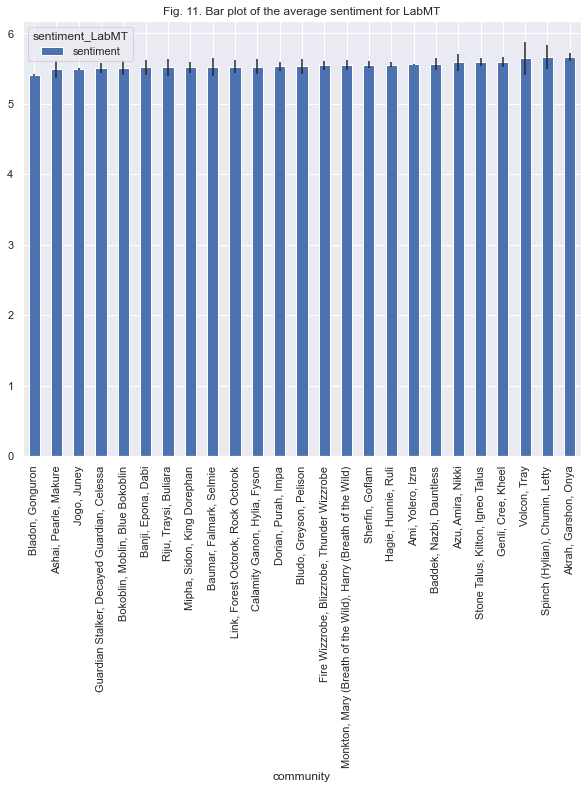

In [433]:
show_bar_plot(df_gcc_dialogues, sentiment_source="sentiment_LabMT", title="Fig. 11. Bar plot of the average sentiment for LabMT")

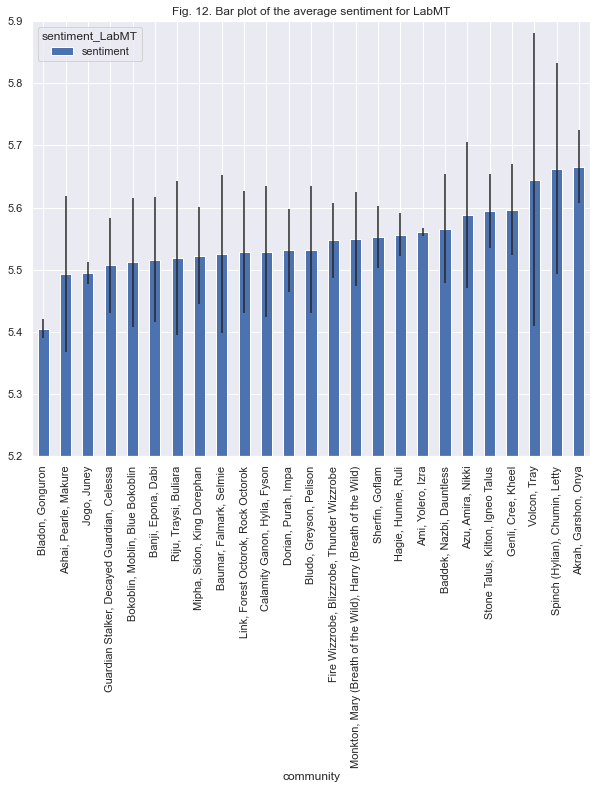

In [435]:
# For readability, the bar plot will start at 5
show_bar_plot(df_gcc_dialogues, sentiment_source="sentiment_LabMT", ylim=(5.2, 5.9), title="Fig. 12. Bar plot of the average sentiment for LabMT")

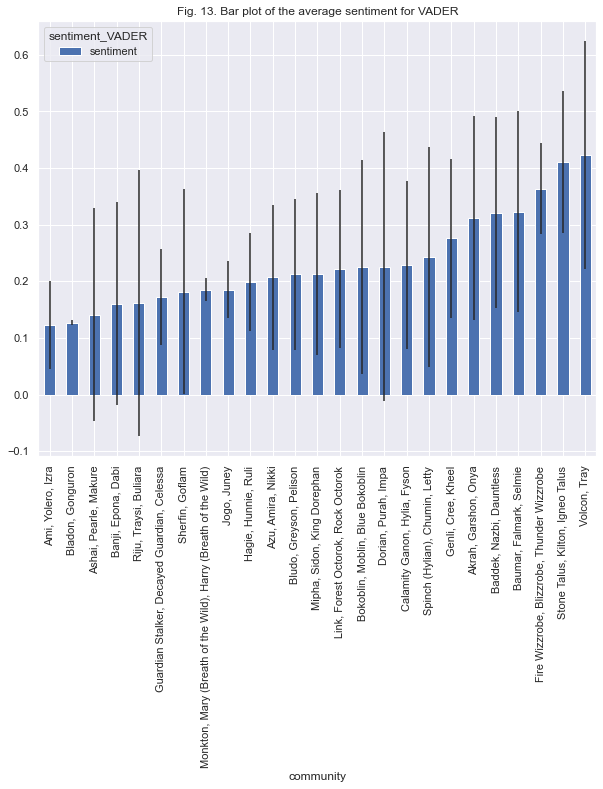

In [436]:
show_bar_plot(df_gcc_dialogues, sentiment_source="sentiment_VADER", title="Fig. 13. Bar plot of the average sentiment for VADER")

> * **Explain the difference between the two methods and compare the results you have obtained above.**

Word-level sentiment is a score describing the emotional connotations of it. In [this paper](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) it is described how these scores are computed. In short, authors have extracted 50k most common words in tweets, divided them to chunks of 10 and paid people at Mechanical Turk to rank/sort the words based on their view of how positive these words are. The resulting indexes of these words are later used as a score of the positivity.

In this exercise there are two methods implemented, which are refered to as LabMT and VADER. LabMT method as implemented here bases only on the sentiment score of each of the words in text, as an arithmetic average of each words score. 

On the other hand, VADER (Valence Aware Dictionary and Sentiment Reasoner) is a rule based method, but it also leverages on the previously mentioned word-level sentiment scores. However, it uses concepts such as boosters and negators to accordingly scale and flip sentiments of the words. 

Summing up, the difference between these methods is that LabMT only takes into consideration each words sentiment, while VADER attempts to interpret the sentence as a whole, with words in it interacting with each other, as well as the interpunction.

In order to do a more quantitative analysis, first, let us look how correlated are the scores of both the methods:

In [417]:
round(df_gcc_dialogues["sentiment_VADER"].corr(df_gcc_dialogues["sentiment_LabMT"]), 3)

0.513

We notice that there is a positive, however not very significant correlation between these scores.

Another way of comparing these two sentiment-mining methods is by treating their results as a ranking. As they both describe the same dialogues, we can use method called Rank-biased Overlap (RBO) described in [this paper](http://w.codalism.com/research/papers/wmz10_tois.pdf).

In [418]:
vader_rank = list(df_gcc_dialogues.sort_values("sentiment_VADER")["Name"])
labmt_rank = list(df_gcc_dialogues.sort_values("sentiment_LabMT")["Name"])

round(rbo.RankingSimilarity(vader_rank, labmt_rank).rbo(), 3)

0.666

Again, the results are somewhat similar, but not to a great degree. (Score of 0 would signify no similarity, 1 would signify these ranking are the same.)

Using the summaries established previously (top10 saddest, happiest characters) we can find out how many of the extreme scores are consistent across methods:

In [420]:
last10_labmt = set(df_gcc_dialogues.nsmallest(10, "sentiment_LabMT")["Name"])
last10_vader = set(df_gcc_dialogues.nsmallest(10, "sentiment_VADER")["Name"])
intersection = last10_labmt.intersection(last10_vader)
len(intersection), intersection

(4, {'Flaxel', 'Kotta', 'Palme', 'Strade'})

In [421]:
top10_labmt = set(df_gcc_dialogues.nlargest(10, "sentiment_LabMT")["Name"])
top10_vader = set(df_gcc_dialogues.nlargest(10, "sentiment_VADER")["Name"])
intersection = top10_labmt.intersection(top10_vader)
len(intersection), intersection

(2, {'Kula', 'Toren'})

Again, we find that both the methods are moderately similar. The same findings we got from the top 3 happiest and saddest communities comparison: in the 3 happiest communities only 1 was the same: 'Rensa, Cotera, Darton'. For the 3 saddest the similarity is greater: 'Quince, Satty, Lawdon' and 'Vilia, Canolo, Sasa Kai'.

> * **What is the advantage of using a rule-based method over the dictionary-based approach?**

The advantage of using the rule-based method over the dictionary-based approach is the quality of the resulting scores for whole texts. We see, that VADER does much better job than LabMT in cases that require more "holistic" approach.

Let us consider the sentence *"I do not like what I see!"*.

In [423]:
compute_sentiment_VADER(["I do not like what I see!"])

-0.3404

In [424]:
compute_sentiment_LabMT(preprocess(["I do not like what I see!"]))

5.648571428571428

We find, that while VADER manages to notice that word "not" and "like" interact in a way which makes the whole sentence a negative one, the LabMT failes at it, giving the score of 5.65, which compared to other LabMT scores is quite a high score.